# Getting Meta with Big Data Malaysia
Scraping the Big Data Malaysia Facebook group for fun. Profit unlikely.

## Hello World

This is an introductory-level notebook demonstrating how to deal with a small, but meaty dataset. Things we will do here include:

* Loading a JSON dataset.
* Dealing with a minor data quality issue.
* Handling timestamps.
* Dataset slicing and dicing.
* Plotting histograms.

A "follow the data" approach will be taken. This notebook may appear quite long, but a good portion of the length is pretty-printing of raw data which noone is expected to read in entirety, but it's there for one to skim to get an idea of the structure of our data.

## Get all the data
This notebook assumes you have already prepared a flattened JSON file into `all_the_data.json`, which you would have done by:
* Writing your oauth token into `oauth_file` according to the instructions in `pull_feed.py`.
* Running `python pull_feed.py` to pull down the feed pages into the BigDataMyData directory.
* Running `python flatten_saved_data.py > all_the_data.json`.

In [1]:
# we need this for later:
%matplotlib inline

import json
INPUT_FILE = "all_the_data.json"
with open(INPUT_FILE, "r") as big_data_fd:
	big_data = json.load(big_data_fd)

## Is it big enough?
Now we have all our data loaded into variable `big_data`, but can we really say it's Big Data?

In [2]:
print "We have {} posts".format(len(big_data))

We have 1946 posts


Wow! So data! Very big!

Seriously though... it's not big. In fact it's rather small. How small is small? Here's a clue...

In [3]:
import os
print "The source file is {} bytes. Pathetic.".format(os.stat(INPUT_FILE).st_size)

The source file is 3773450 bytes. Pathetic.


At the time this was written, the file was just about 3MB, and there were fewer than 2k posts... note that excludes comments made on posts, but still, this stuff is small. It is small enough that at no point do we need to do anything clever from a data indexing/caching/storage perspective, so to start we will take the simplistic but often appropriate approach of slicing and dicing our `big_data` object directly. Later on we'll get into `pandas` `DataFrame` objects.

Anyway, size doesn't matter. It's *variety* that counts.

## Fields of gold

Now we know how many elements (rows I guess?) we have, but how much variety do we have in this data? One measure of this may be to look at the number of fields in each of those items:

In [4]:
import itertools
all_the_fields = set(itertools.chain.from_iterable(big_data))
print "We have {} different field names:".format(len(all_the_fields))
print all_the_fields

We have 30 different field names:
set([u'application', u'actions', u'likes', u'created_time', u'message', u'id', u'story', u'from', u'subscribed', u'privacy', u'comments', u'shares', u'to', u'story_tags', u'type', u'status_type', u'picture', u'description', u'object_id', u'link', u'properties', u'icon', u'name', u'message_tags', u'with_tags', u'updated_time', u'caption', u'place', u'source', u'is_hidden'])


Are we missing anything? A good way to sanity check things is to actually inspect the data, so let's look at a random item:

In [5]:
import random
import pprint
# re-run this as much as you like to inspect different items
pprint.pprint(random.choice(big_data))

{u'actions': [{u'link': u'https://www.facebook.com/497068793653308/posts/961960940497422',
               u'name': u'Comment'},
              {u'link': u'https://www.facebook.com/497068793653308/posts/961960940497422',
               u'name': u'Like'},
              {u'link': u'/groups/bigdatamy/', u'name': u'Create Group Chat'}],
 u'application': {u'id': u'183319479511',
                  u'name': u'Hootsuite',
                  u'namespace': u'hootsuiteprod'},
 u'created_time': u'2014-10-21T02:15:17+0000',
 u'from': {u'id': u'10152418624011789', u'name': u'John F.X. Berns'},
 u'id': u'497068793653308_961960940497422',
 u'is_hidden': False,
 u'message': u'Hadoop World: The executive dashboard is on the way out - http://ow.ly/D3eF1',
 u'privacy': {u'allow': u'',
              u'deny': u'',
              u'description': u'',
              u'friends': u'',
              u'value': u''},
 u'to': {u'data': [{u'id': u'497068793653308',
                    u'name': u'Big Data Malaysia'}]},
 u

From that you should be able to sense that we are missing some things - it isn't simply that there are some number of fields that describe each item, because some of those fields have data hierarchies beneath them, for example:

In [6]:
pprint.pprint(big_data[234])

{u'actions': [{u'link': u'https://www.facebook.com/497068793653308/posts/1032324310127751',
               u'name': u'Comment'},
              {u'link': u'https://www.facebook.com/497068793653308/posts/1032324310127751',
               u'name': u'Like'},
              {u'link': u'/groups/bigdatamy/', u'name': u'Create Group Chat'}],
 u'comments': [{u'data': [{u'can_remove': True,
                           u'created_time': u'2015-02-02T14:20:46+0000',
                           u'from': {u'id': u'10203864949854090',
                                     u'name': u'Teuku Faruq'},
                           u'id': u'1033140356712813',
                           u'like_count': 1,
                           u'message': u'Interesting startup, all the best!',
                           u'user_likes': False},
                          {u'can_remove': True,
                           u'created_time': u'2015-02-04T07:45:13+0000',
                           u'from': {u'id': u'10203477707997024',


From that we can see some fields have hierarchies within them, e.g. likes have a list of id dictionaries, which happen to be relatively trivial (names and ids... I wonder why Facebook didn't just post the id and make you look up the name?) but the comment field is a bit more complex, wherein it contains a list of dictionaries with each field potentially being a dictionary of its own, e.g. we can see that the second comment on that post tagged Teuku Faruq:

In [7]:
pprint.pprint(big_data[234]['comments'][0]['data'][1]['message_tags'])

[{u'id': u'10203864949854090',
  u'length': 11,
  u'name': u'Teuku Faruq',
  u'offset': 10,
  u'type': u'user'}]


## Data quality annoyances

Actually I'm not even sure why the `comments` field is a single entry list. Is that always the case?

In [8]:
set([len(data['comments']) for data in big_data if 'comments' in data])

{1, 2}

Apparently that's not always the case, sometimes there are 2 items in the list, let's see what that looks like...

In [9]:
multi_item_comment_lists = [data['comments'] for data in big_data if ('comments' in data) and (len(data['comments']) > 1)]
print len(multi_item_comment_lists)
pprint.pprint(multi_item_comment_lists[0])

4
[{u'data': [{u'can_remove': True,
             u'created_time': u'2015-02-27T03:39:29+0000',
             u'from': {u'id': u'10152465206977702', u'name': u'Peter Ho'},
             u'id': u'1049191648441017',
             u'like_count': 0,
             u'message': u'Peter the slide share has 404 message?',
             u'user_likes': False},
            {u'can_remove': True,
             u'created_time': u'2015-02-27T03:43:23+0000',
             u'from': {u'id': u'10152075362431725',
                       u'name': u'Tirath Ramdas'},
             u'id': u'1049192758440906',
             u'like_count': 0,
             u'message': u'Works for me',
             u'user_likes': False},
            {u'can_remove': True,
             u'created_time': u'2015-02-27T03:43:46+0000',
             u'from': {u'id': u'10152934839784580', u'name': u'Peter Kua'},
             u'id': u'1049192845107564',
             u'like_count': 0,
             u'message': u'works from side too Peter Ho',
         

Skimming the above it looks as though very long comment threads are split into multiple "pages" in the `comments` list. This may be an artifact of the paging code in `pull_feed.py`, which is not ideal. At some point we may fix it there, but for the time being we'll just consider it a data quality inconvenience that we will have to deal with.

Here's a function to work around this annoyance:

In [10]:
def flatten_comments_pages(post):
    flattened_comments = []
    for page in post:
        flattened_comments += page['data']
    return flattened_comments

post_comments_paged = multi_item_comment_lists[0]
print "Post has {} comments".format(len(flatten_comments_pages(post_comments_paged)))

Post has 40 comments


## Start plotting things already dammit

Now that we're counting comments, it's natural to ask: what does the number-of-comments-per-post distribution look like? 

**IMPORTANT NOTE**: Beyond this point, we start to "follow the data" as we analyse things, and we do so in a time-relative way (e.g. comparing the last N days of posts to historical data). As Big Data Malaysia is a living breathing group, the data set is a living breathing thing, so things may change, and the conclusions informing the analysis here may suffer *logic rot*.

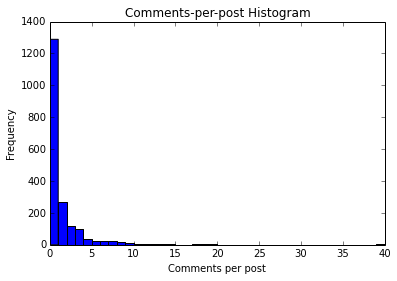

In [11]:
comments_threads = [data['comments'] for data in big_data if 'comments' in data]
count_of_posts_with_no_comments = len(big_data) - len(comments_threads)
comments_counts = [0] * count_of_posts_with_no_comments
comments_counts += [len(flatten_comments_pages(thread)) for thread in comments_threads]

import matplotlib.pyplot as plt
plt.hist(comments_counts, bins=max(comments_counts))
plt.title("Comments-per-post Histogram")
plt.xlabel("Comments per post")
plt.ylabel("Frequency")
plt.show()

This sort of adds up intuitively; posts with long comment threads will be rare, though from experience with this forum it does not seem right to conclude that there is a lot of posting going on with no interaction... the community is a bit more engaged than that. 

But since this is Facebook, comments aren't the only way of interacting with a post. There's also the wonderful 'Like'.

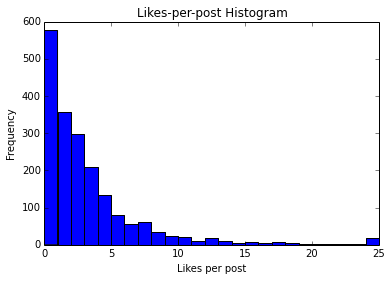

In [12]:
likes_threads = [data['likes']['data'] for data in big_data if 'likes' in data]
count_of_posts_with_no_likes = len(big_data) - len(likes_threads)
likes_counts = [0] * count_of_posts_with_no_likes
likes_counts += [len(thread) for thread in likes_threads]

plt.hist(likes_counts, bins=max(likes_counts))
plt.title("Likes-per-post Histogram")
plt.xlabel("Likes per post")
plt.ylabel("Frequency")
plt.show()

Note that the above does not include Likes on Comments made on posts; only Likes made on posts themselves are counted.

While this paints the picture of a more engaged community, it still doesn't feel quite right. It seems unusual these days to find a post go by without a Like or two.

I have a hunch that the zero-like posts are skewed a bit to the earlier days of the group. To dig into that we'll need to start playing with timestamps. Personally I prefer to deal with time as UTC epoch seconds, and surprisingly it seems I need to write my own helper function for this.

In [13]:
import datetime
import dateutil
import pytz

def epoch_utc_s(date_string):
    dt_local = dateutil.parser.parse(str(date_string))
    dt_utc = dt_local.astimezone(pytz.utc)
    nineteenseventy = datetime.datetime(1970,1,1)
    epoch_utc = dt_utc.replace(tzinfo=None) - nineteenseventy
    return int(epoch_utc.total_seconds())

posts_without_likes = [data for data in big_data if 'likes' not in data]
posts_with_likes = [data for data in big_data if 'likes' in data]
timestamps_of_posts_without_likes = [epoch_utc_s(post['created_time']) for post in posts_without_likes]
timestamps_of_posts_with_likes = [epoch_utc_s(post['created_time']) for post in posts_with_likes]

import numpy
median_epoch_liked = int(numpy.median(timestamps_of_posts_with_likes))
median_epoch_non_liked = int(numpy.median(timestamps_of_posts_without_likes))
print "Median timestamp of posts without likes: {} ({})".format(datetime.datetime.fromtimestamp(median_epoch_non_liked),
                                                                median_epoch_non_liked)
print "Median timestamp of posts with likes: {} ({})".format(datetime.datetime.fromtimestamp(median_epoch_liked),
                                                             median_epoch_liked)

Median timestamp of posts without likes: 2014-04-25 03:08:38 (1398359318)
Median timestamp of posts with likes: 2014-08-29 03:13:29 (1409246009)


In general it seems my hunch may have been right, but it will be clearer if we plot it.

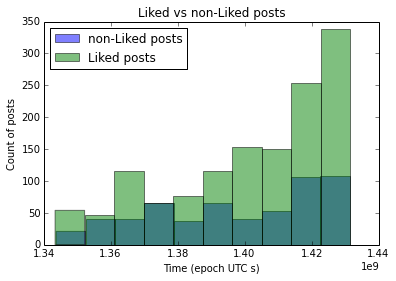

In [14]:
plt.hist(timestamps_of_posts_without_likes, alpha=0.5, label='non-Liked posts')
plt.hist(timestamps_of_posts_with_likes, alpha=0.5, label='Liked posts')
plt.title("Liked vs non-Liked posts")
plt.xlabel("Time (epoch UTC s)")
plt.ylabel("Count of posts")
plt.legend(loc='upper left')
plt.show()

This is looking pretty legit now. We can see that lately there's been a significant uptick in the number of posts, and an uptick in the ratio of posts that receive at least one Like.

As another sanity check, we can revisit the *Likes-per-post Histogram*, but only include recent posts. While we're at it we might as well do the same for the *Comments-per-post Histogram*.

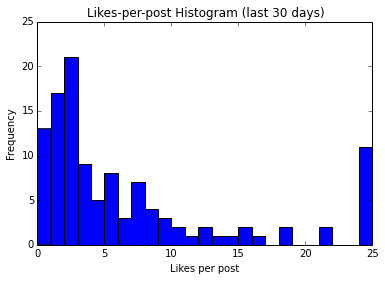

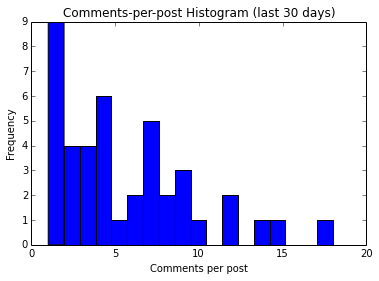

In [15]:
def less_than_n_days_ago(date_string, n):
    query_date = epoch_utc_s(date_string)
    today_a_year_ago = epoch_utc_s(datetime.datetime.now(pytz.utc) - datetime.timedelta(days=n))
    return query_date > today_a_year_ago

# try changing this variable then re-running this cell...
days_ago = 30

# create a slice of our big_data containing only posts created n days ago
recent_data = [data for data in big_data if less_than_n_days_ago(data['created_time'], days_ago)]

# plot the Likes-per-post Histogram for recent_data
recent_likes_threads = [data['likes']['data'] for data in recent_data if 'likes' in data]
recent_count_of_posts_with_no_likes = len(recent_data) - len(recent_likes_threads)
recent_likes_counts = [0] * recent_count_of_posts_with_no_likes
recent_likes_counts += [len(thread) for thread in recent_likes_threads]

plt.hist(recent_likes_counts, bins=max(recent_likes_counts))
plt.title("Likes-per-post Histogram (last {} days)".format(days_ago))
plt.xlabel("Likes per post")
plt.ylabel("Frequency")
plt.show()

# plot the Comment-per-post Histogram for recent_data
recent_comments_threads = [data['comments'] for data in recent_data if 'comments' in data]
recent_count_of_posts_with_no_comments = len(recent_data) - len(comments_threads)
recent_comments_counts = [0] * recent_count_of_posts_with_no_comments
recent_comments_counts += [len(flatten_comments_pages(thread)) for thread in recent_comments_threads]

plt.hist(recent_comments_counts, bins=max(recent_comments_counts))
plt.title("Comments-per-post Histogram (last {} days)".format(days_ago))
plt.xlabel("Comments per post")
plt.ylabel("Frequency")
plt.show()

At the time of writing, histogramming Comments-per-post and Likes-per-post for only posts made within the last 30 days revelaed some interesting things:

* In this period there were very few posts that received 0 likes. But more interestingly...
* There were 0 posts that received 0 comments. That means there were posts that did not get any likes that got at least 1 comment.

Clicking 'Like' is a pretty cheap/lazy form of engagement. It takes a bit more effort to write and send a comment. There is too little here to form any conclusions, but it does make one think about how we may measure engagement levels, and whether or not this bodes well as an early indicator that the *Big Data Malaysia* community is becoming more engaged.

## Coming soon...
There is much more that can be done, but let's pause for now to review what we've done up to here:

* We've loaded a JSON dataset.
* We've dealt with a bit of an annoying data quality issue (i.e. the unfortunate business with the sloppy comments field paging).
* We've parsed timestamps from strings.
* We've done some slicing and dicing of the dataset with *list comprehensions* and *itertools* to take slices of our data that matched some criteria (i.e. posts with comments, posts created within the last 30 days).
* We've plotted some histograms.
* We've just about started to scratch the surface with `numpy` and `pandas` - much more to come here.

The reward to this stuff is learning something new, and by the end of this exercise we learned a little bit about the engagement habits of the Big Data Malaysia community. Soon we will pick up where this notebook has left off, and dig deeper into that issue.